# Computer Generated Holography

<a target="_blank" href="https://colab.research.google.com/github/chromatix-team/chromatix/blob/main/docs/examples/cgh.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

IFF you are using Google Colab, first you need to install the packages as follows. If you are running locally and have the package installed skip the next code block:

In [ ]:
!pip install --upgrade pip
!pip install git+https://github.com/chromatix-team/chromatix.git

In this example, we'll demonstrate computer generated holography (CGH). In CGH, the goal is to learn to produce a target hologram by perturbing a wavefront of light at only one plane. A real CGH application would have to be much more complex to account for the mismatch between simulation and reality, and also then evaluate how well the system generates a real hologram. Here, we will be dealing only in the simulation of an ideal system for CGH to demonstrate how one can optimize parameters of a system in Chromatix. We'll base our optical setup on [1]: [DeepCGH: 3D computer-generated holography using deep learning](https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-18-26636&id=437573), though we won't be demonstrating the deep learning method discussed in that work. Instead, we'll directly optimize parameters of our optical system to reproduce a fixed target hologram.

In [15]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import flax.linen as nn
from functools import partial
from flax.training.train_state import TrainState

from optax import adam
import optax

from skimage.data import cells3d
import matplotlib.pyplot as plt

from chromatix import Field
from chromatix.systems import OpticalSystem
from chromatix.elements import PlaneWave, AmplitudeMask, PhaseMask, FFLens, Propagate, trainable
from chromatix.utils import flat_phase

from typing import Any, Callable, Optional, Sequence, Tuple
from chex import Array

key = random.PRNGKey(4)

## Modeling holography

Creating a CGH model is straightforward using Chromatix. See the [Holoscope example](https://chromatix.readthedocs.io/en/latest/examples/holoscope/) for a walkthrough of putting together a `Module` that wraps up everything you want to parameterize for optimization. Here, we're making a very simple CGH model that uses a phase mask, which has trainable pixels initialized to 0.

In [2]:
class CGH(nn.Module):
    shape: Tuple[int, int]
    spacing: float
    z: Array
    f: float = 200.0
    n: float = 1.0
    NA: Optional[float] = None
    N_pad: int = 0
    spectrum: Array = 1.035
    spectral_density: Array = 1.0
    @nn.compact
    def __call__(self) -> Field:
        # Chromatix does the work of simulating the propagation of the plane wave into
        # the desired hologram at multiple depths. This lets us define a CGH simulation
        # in just a few lines.
        system = OpticalSystem([
            PlaneWave(
                shape=self.shape,
                dx=self.spacing,
                spectrum=self.spectrum,
                spectral_density=self.spectral_density
            ),
            PhaseMask(trainable(flat_phase, rng=False)),
            FFLens(self.f, self.n, self.NA),
            Propagate(self.z, self.n, method="transfer"),
        ])
        return system()

We can initialize the model just like any `Module` in Flax:

In [3]:
# Parameters are taken from the paper, we just use 256, 256 because of our data
shape = (256, 256)
spacing = 9.2
z = jnp.linspace(0, 100, num=51) # Planes we want to simulate the hologram at
model = CGH(shape=shape, spacing=spacing, z=z)
variables = model.init(key)

# Split into two
params, state = variables["params"], variables["state"]
del variables # delete for memory

Let's check that the resulting output has the correct spacing, which we know from [[1]](https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-18-26636&id=437573).

In [4]:
# We can call the model to get the field at a given z:
output_field = model.apply({"params": params, "state": state})
# This matches the spacing in the paper
print(output_field.grid[30].max() - output_field.grid[30].min())

22.412111


We see that now we have a `Field` which has a batch dimension size of 51, which is the number of planes we wanted to simulate:

In [5]:
# The intensity now has shape 51 x 256 x 256 x 1
print(model.apply({"params":params, "state": state}).intensity.shape)

(51, 256, 256, 1, 1)


## Creating a 3D target hologram

We'll try to make a hologram that creates three spherical spots in 3D at arbitrary locations. This is certainly a very simple target hologram, but is meant to mimic the kind of target that could be used to optogenetically stimulate neurons as described in [[1]](https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-18-26636&id=437573).

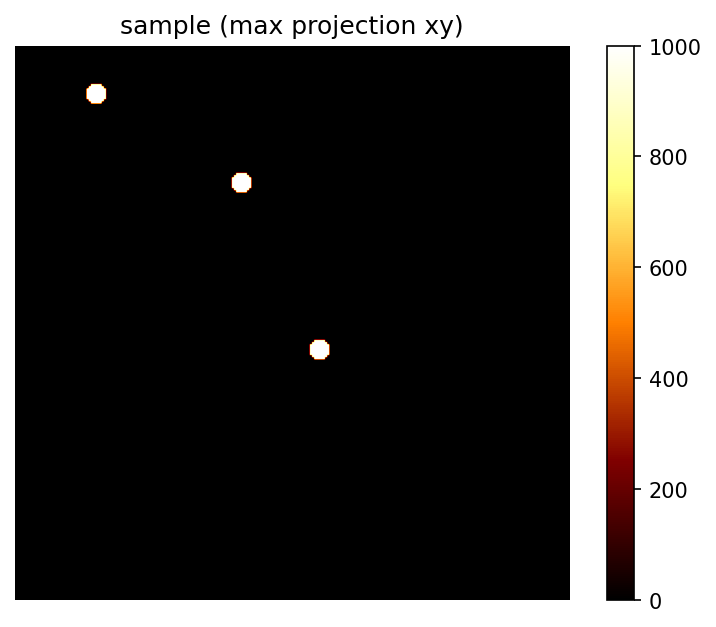

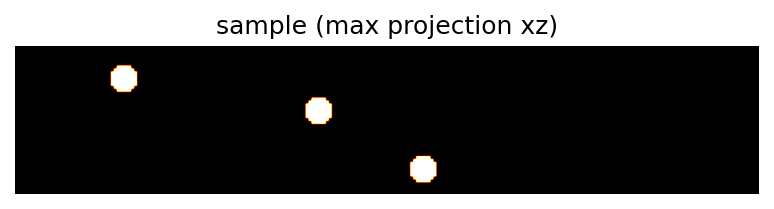

In [6]:
sample = np.zeros((51, 256, 256))
sample[30, 128, 128] = 1.0
sample[10, 51, 92] = 1.0
sample[50, 10, 25] = 1.0
diameter = 25
kernel = np.zeros((diameter, diameter, diameter))
grid = np.meshgrid(
    np.linspace(-diameter / 2, diameter / 2, num=diameter),
    np.linspace(-diameter / 2, diameter / 2, num=diameter),
    np.linspace(-diameter / 2, diameter / 2, num=diameter)
)
grid = np.sqrt(grid[0] ** 2 + grid[1] ** 2 + grid[2] ** 2)
kernel[grid < diameter / 5] = 1.0
sample = jnp.fft.ifftn(jnp.fft.fftn(jnp.array(sample)) * jnp.fft.fftn(jnp.array(kernel), s=sample.shape)).real
sample = sample[..., jnp.newaxis, jnp.newaxis]
sample *= 1000.0

plt.figure(dpi=150)
plt.imshow((sample).max(0).squeeze(), cmap="afmhot")
plt.axis("off")
plt.colorbar()
plt.title("sample (max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow((sample).max(1).squeeze(), cmap="afmhot")
plt.axis("off")
plt.title("sample (max projection xz)")
plt.show()

## Optimizing the CGH system

At first, since our phase mask isn't doing very much, we can see that we just get a single spot as our generated hologram:

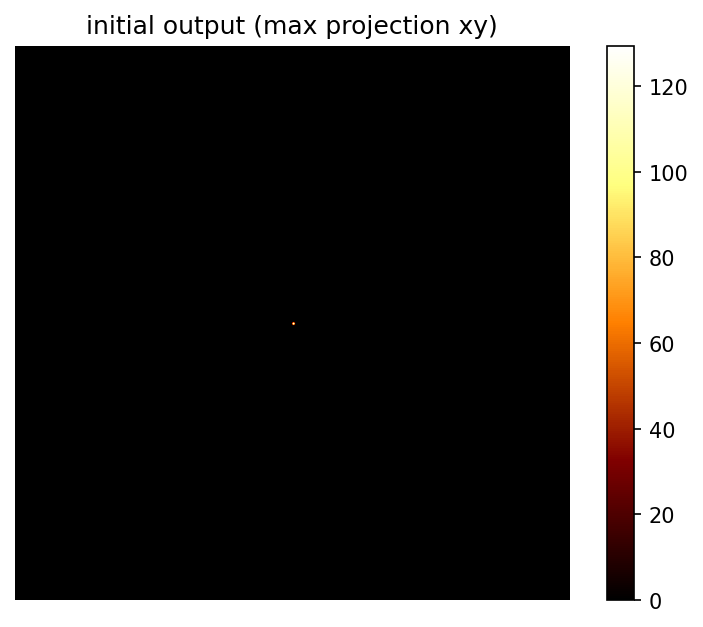

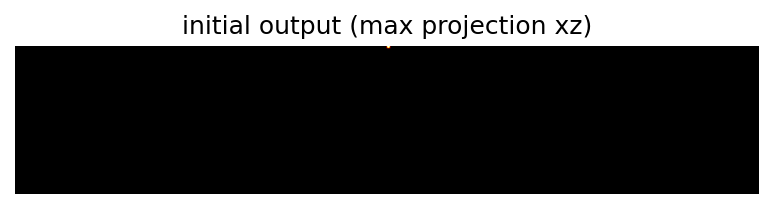

In [7]:
learned = model.apply({"params": params, "state": state}).intensity.squeeze()

plt.figure(dpi=150)
plt.imshow((learned).max(0).squeeze(), cmap="afmhot")
plt.axis("off")
plt.colorbar()
plt.title("initial output (max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow((learned).max(1).squeeze(), cmap="afmhot")
plt.axis("off")
plt.title("initial output (max projection xz)")
plt.show()

Let's set up a few functions to optimize our phase mask and produce the target we want. First, we'll need to compute the loss and its gradient. We'll use an inverse Pearson correlation as our loss:

In [8]:
def loss_fn(params, state, target):
    # eps = 1e-6
    approx = model.apply({"params": params, "state": state}).intensity
    correlation = jnp.corrcoef(approx.flatten(), target.flatten())[0, 1]
    loss = 1.0 - correlation
    # loss = optax.cosine_distance(predictions=approx.reshape(-1), targets=target.reshape(-1), epsilon=eps).mean()
    return loss, {"loss": loss, "correlation": correlation}

print(loss_fn(params, state, sample))

(Array(0.9999865, dtype=float32), {'loss': Array(0.9999865, dtype=float32), 'correlation': Array(1.3483872e-05, dtype=float32)})


We can look at what the gradient of that loss looks like on our phase mask pixel parameters:

In [9]:
grad_fn = jax.jit(jax.grad(loss_fn, has_aux=True))
print(grad_fn(params, state, sample)[0]["PhaseMask_0"]["_phase"][:4, :4])

[[ 1.6559855e-07  2.0166650e-07 -1.0441321e-07  2.1300623e-07]
 [ 8.8400959e-08 -5.9660429e-08 -1.0040580e-07 -7.5648025e-08]
 [-3.8274173e-08 -2.6384319e-08 -2.2631380e-07  2.0573317e-07]
 [-1.5947190e-07 -1.3266684e-07  2.6866056e-07 -1.6032081e-07]]


These gradients seem reasonable enough. Next, we'll need an optimizer, for which we'll reach for Optax. Optax contains most of the typical optimizers used in deep learning. We'll use Adam for now.

In [10]:
optimizer = adam(learning_rate=1e-1)

Now we can write the training loop. Since we want to compile as much code as we can, we'll try to compile one entire step of training --- including the forward simulation, computing the loss and the gradient with respect to the phase mask pixel parameters, and finally using the gradient with Adam to update the parameters. This can all happen in relatively few lines. We can also report some metrics along the way, courtesy of our loss function which returns a dictionary of loss and correlation values for each step.

In [11]:
# Setting the state which has the model, params and optimiser
trainstate = TrainState.create(
    apply_fn=model.apply, 
    params=params, 
    tx=optimizer
)

Running the training loop is pretty straightforward:

In [12]:
%%time
max_iterations = 1000
history = {"loss": np.zeros((max_iterations)), "correlation": np.zeros((max_iterations))}
for iteration in range(max_iterations):
    grads, metrics = grad_fn(trainstate.params, state, sample) 
    trainstate = trainstate.apply_gradients(grads=grads)
    for m in metrics:
        history[m][iteration] = metrics[m]
    if iteration % 200 == 0:
        print(iteration, metrics)

0 {'correlation': Array(1.3483872e-05, dtype=float32), 'loss': Array(0.9999865, dtype=float32)}
200 {'correlation': Array(0.6895132, dtype=float32), 'loss': Array(0.3104868, dtype=float32)}
400 {'correlation': Array(0.6987673, dtype=float32), 'loss': Array(0.3012327, dtype=float32)}
600 {'correlation': Array(0.70209336, dtype=float32), 'loss': Array(0.29790664, dtype=float32)}
800 {'correlation': Array(0.7047197, dtype=float32), 'loss': Array(0.29528028, dtype=float32)}
CPU times: user 1min 40s, sys: 4.96 s, total: 1min 45s
Wall time: 52 s


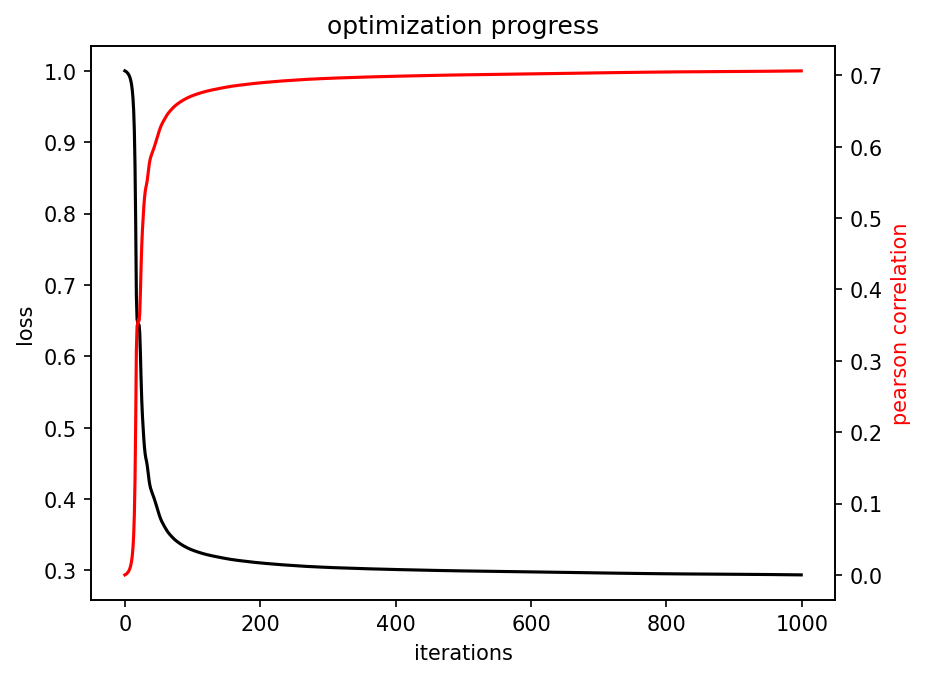

In [13]:
fig, ax1 = plt.subplots(dpi=150)

ax1.plot(np.array(history["loss"]), color="black")
ax1.set_ylabel("loss")
ax1.set_xlabel("iterations")

ax2 = ax1.twinx()
ax2.plot(np.array(history["correlation"]), color="red")
ax2.set_ylabel("pearson correlation", color="red")
plt.title("optimization progress")
plt.show()

## Evaluation

So finally we can see how we did! We'll simulate the forward pass of our optical system with our learned phase mask pixels to see what we expect the hologram to look like after training:

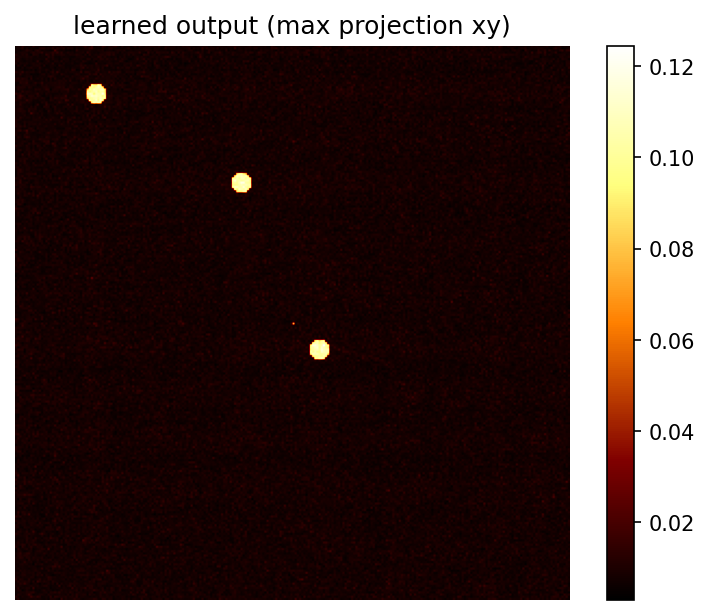

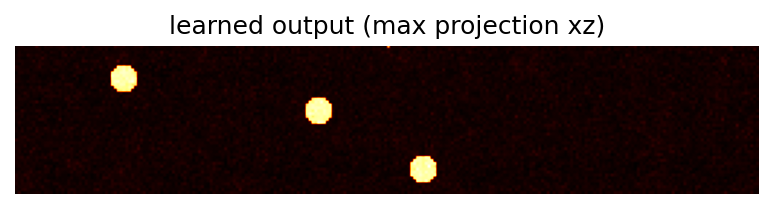

In [14]:
learned = model.apply({"params": trainstate.params, "state": state}).intensity.squeeze()

plt.figure(dpi=150)
plt.imshow((learned).max(0).squeeze(), cmap="afmhot")
plt.axis("off")
plt.colorbar()
plt.title("learned output (max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow((learned).max(1).squeeze(), cmap="afmhot")
plt.axis("off")
plt.title("learned output (max projection xz)")
plt.show()

We can see our basic 3D target hologram! We could still improve this in many ways --- we'll leave these as an exercise to the reader.